In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import scipy
import pandas_profiling 
import criteo_ml

In [2]:
!ls

__pycache__
Criteo EDA.ipynb
criteo_ml.py
fast_solution_small.py
fields.txt
leaderboard.csv
missing-data.png
prepare.sh
readme.txt
test.txt
test_half.txt
train.txt
train_half.txt
train_small.txt
train_smaller.txt


# Criteo Display Advertising Challenge EDA and XGBoost Demonstration

Below are the files for this notebook.  Originally, these consisted of competition files readme.txt, train.txt, and test.txt.  Shell script prepare.sh splits the data a first training half (train_half.txt) and a second testing half (test_half.txt).  Also the first 1000000 lines of train.txt are in train_small.txt for exploratory data analysis (EDA) and early experiments in the interest of computational time and memory.

# Here we see Criteo Lab's description of the dataset:

In [3]:
!less readme.txt

        ------ Display Advertising Challenge ------

Dataset: dac-v1

This dataset contains feature values and click feedback for millions of display 
ads. Its purpose is to benchmark algorithms for clickthrough rate (CTR) prediction.
It has been used for the Display Advertising Challenge hosted by Kaggle:
https://www.kaggle.com/c/criteo-display-ad-challenge/


Full description:

This dataset contains 2 files:
  train.txt
  test.txt
corresponding to the training and test parts of the data. 


Dataset construction:

The training dataset consists of a portion of Criteo's traffic over a period
of 7 days. Each row corresponds to a display ad served by Criteo and the first
column is indicates whether this ad has been clicked or not.
The positive (clicked) and negatives (non-clicked) examples have both been
subsampled (but at different rates) in order to reduce the dataset size.

There are 13 features taking integer values (mostly count features) and 26
categorical features. The values of th

In [4]:
!head -3 train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16
0	2	0	44	1	102	8	2	2	4	1	1		4	68fd1e64	f0cf0024	6f67f7e5	41274cd7	25c83c98	fe6b92e5	922afcc0	0b153874	a73ee510	2b53e5fb	4f1b46f3	623049e6	d7020589	b28479f6	e6c5b5cd	c92f3b61	07c540c4	b04e4670	21ddcdc9	5840adea	60f6221e		3a171ecb	43f13e8b	e8b83407	731c3655
0	2	0	1	14	767	89	4	2	245	1	3	3	45	287e684f	0a519c5c	02cf9876	c18be181	25c83c98	7e0ccccf	c78204a1	0b153874	a73ee510	3b08e48b	5f5e6091	8fe001f4	aa655a2f	07d13a8f	6dc710ed	36103458	8efede7f	3412118d			e587c466	ad3062eb	3a171ecb	3b183c5c		


# Competition scoring details:

Submissions are evaluated using the Logarithmic Loss (smaller is better).

Submission Format
The submissions should contain the predicted probability of click for each ad impression in the test set using the following format:

Id,Predicted
60000000,0.384
63895816,0.5919
759281658,0.1934
895936184,0.9572
...

## The private leaderboard is calculated with approximately 80% of the test data.

I have placed the private leaderboard scoring in leaderboard.csv.  Below is a snapshot of that data.  It is important to note that forum posts towards the end of the competition that offered significant guidance caused a flurry of submissions with the same/similar performance.


In [5]:
leaderboard = pd.read_csv("leaderboard.csv")
leaderboard.info()
leaderboard['Score'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 2 columns):
#        718 non-null float64
Score    720 non-null float64
dtypes: float64(2)
memory usage: 11.3 KB


count    720.000000
mean       0.584142
std        0.403532
min        0.444630
25%        0.464210
50%        0.479185
75%        0.544375
max        9.074710
Name: Score, dtype: float64

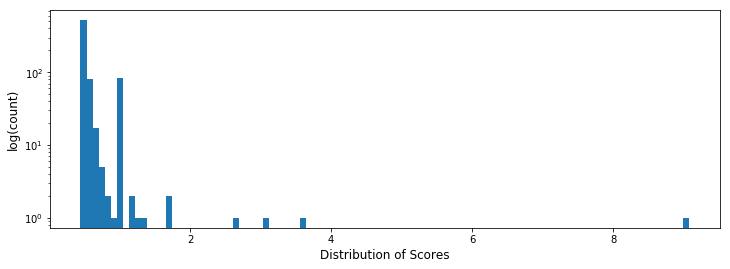

In [6]:
plt.figure(figsize=(12,4))
plt.hist(leaderboard['Score'], bins=100, log=True)
plt.xlabel('Distribution of Scores', fontsize=12)
plt.ylabel('log(count)', fontsize=12)
plt.show()

 Dropping the 4 outliers above 2, we get a clearer picture of this distribution:

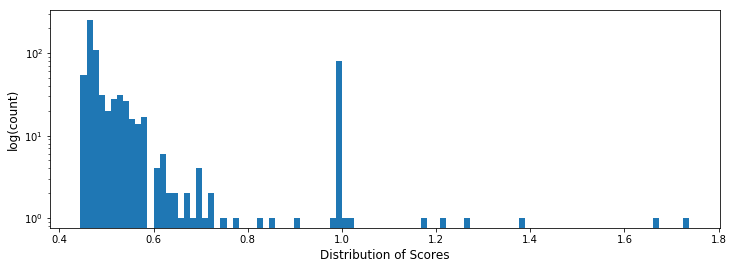

In [7]:
plt.figure(figsize=(12,4))
plt.hist(leaderboard['Score'][:-4], bins=100, log=True)
plt.xlabel('Distribution of Scores', fontsize=12)
plt.ylabel('log(count)', fontsize=12)
plt.show()

Let's define the score function for our data and consider what scores one would get if one always predicted 1, random 0 or 1, and 0:

In [8]:
data = pd.read_csv("train_small.txt", sep='\t', header=None)
n = len(data)

# define score function

def score(y_true, y_pred):
    return log_loss(y_true, y_pred, eps=1e-15)

print("Score for 1 prediction:", score(data[0],  [1] * n))
print("Score for random prediction:", score(data[0],  np.random.randint(2, size=n)))
print("Score for 0 prediction:", score(data[0],  [0] * n))

Score for 1 prediction: 25.7337456327
Score for random prediction: 17.2605330711
Score for 0 prediction: 8.80562650311


Since correct 0 predictions significantly outnumber correct 1, we can see that entrant scores are considerably better than such trivial, poor, baseline predictions.

We can take a published approach with a known private score and use that to correlate to scores for our limited 1M train_small.txt sample.  

A logistic regression approach, documented [here](https://www.kaggle.com/c/criteo-display-ad-challenge/discussion/10322), treats all numeric and categorical data as categorical and makes use of the hashing trick ().  It reportedly has a public leaderboard value of 0.46902 (better than median), which would *rank 299/718 (top 42%)* on the private leaderboard if performance was consistent between the publicly-scored 20% and privately-scored 80% of test data, i.e. one did not overfit to the publicly-scored 20% of test data.

We modify that code to create a better baseline for comparison on our smaller subset of the data in train_small.txt applying 10-fold cross validation





In [9]:
import fast_solution_small

Converting all data to categorical using hashing trick.
Reading data... (1000000, 40)
Converting all features to categorical... done.
Performing 10-fold cross validation:
============================ Fold 1
2018-06-22 22:16:34.307153	encountered: 100000	current logloss: 0.482007
2018-06-22 22:16:36.456050	encountered: 200000	current logloss: 0.487522
2018-06-22 22:16:38.612917	encountered: 300000	current logloss: 0.487538
2018-06-22 22:16:40.768848	encountered: 400000	current logloss: 0.486850
2018-06-22 22:16:42.926940	encountered: 500000	current logloss: 0.485127
2018-06-22 22:16:45.076273	encountered: 600000	current logloss: 0.483130
2018-06-22 22:16:47.226291	encountered: 700000	current logloss: 0.481166
2018-06-22 22:16:49.377281	encountered: 800000	current logloss: 0.479660
2018-06-22 22:16:51.527396	encountered: 900000	current logloss: 0.478108
============================ Fold 2
2018-06-22 22:16:54.239006	encountered: 100000	current logloss: 0.456341
2018-06-22 22:16:56.373850	

With a mean 10-fold CV log-loss of 0.469668 and a [min, max] log-loss range of [0.440505, 0.483416], we see that this logistic regression implementation modification is consistent with the reported 0.46902 log-loss from the original categorical hashing trick logistic regression.

I will henceforth use this mean 10-fold CV log-loss of 0.469668 as a baseline for comparison with more sophisticated techniques to see what they offer on the Criteo dataset.  

Recall also that the public leaderboard top quartile and best were:
min        0.444630
25%        0.464210

and from above, we can treat our logistic regression baseline falls at about 
42%        0.46902 (0.469668 average with our smaller sample and 10-fold CV)

Next, we perform ...


# Exporatory Data Analysis on our 1000000 sample:

In [10]:
pd.options.display.max_rows = 10

# Load in first 1000000 lines of train.txt for Exploratory Data Analysis (EDA)
eda = pd.read_csv("train_small.txt", sep='\t', header=None)
eda.info()
eda.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 40 columns):
0     1000000 non-null int64
1     576997 non-null float64
2     1000000 non-null int64
3     764946 non-null float64
4     750884 non-null float64
5     975464 non-null float64
6     778260 non-null float64
7     959166 non-null float64
8     999338 non-null float64
9     959166 non-null float64
10    576997 non-null float64
11    959166 non-null float64
12    229943 non-null float64
13    750884 non-null float64
14    1000000 non-null object
15    1000000 non-null object
16    963655 non-null object
17    963655 non-null object
18    1000000 non-null object
19    880656 non-null object
20    1000000 non-null object
21    1000000 non-null object
22    1000000 non-null object
23    1000000 non-null object
24    1000000 non-null object
25    963655 non-null object
26    1000000 non-null object
27    1000000 non-null object
28    1000000 non-null object
29    963655 non-null ob

,0,1,2,3,4,...,9,10,11,12,13
count,1000000.000000,576997.000000,1000000.000000,764946.000000,750884.000000,...,959166.000000,576997.000000,959166.000000,229943.000000,750884.000000
mean,0.254949,3.238400,93.965184,21.094269,6.954270,...,105.450931,0.572658,2.507449,0.979991,7.630003
std,0.435833,8.944151,349.884675,344.010001,8.554014,...,217.405401,0.679937,4.825370,6.003874,35.071487
min,0.000000,0.000000,-2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2.000000,2.000000,...,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.000000,2.000000,5.000000,4.000000,...,39.000000,0.000000,1.000000,0.000000,4.000000
75%,1.000000,3.000000,32.000000,14.000000,9.000000,...,110.000000,1.000000,3.000000,0.000000,9.000000
max,1.000000,780.000000,18522.000000,65535.000000,507.000000,...,19327.000000,8.000000,147.000000,768.000000,6702.000000


First, let's look at histograms for numeric features:

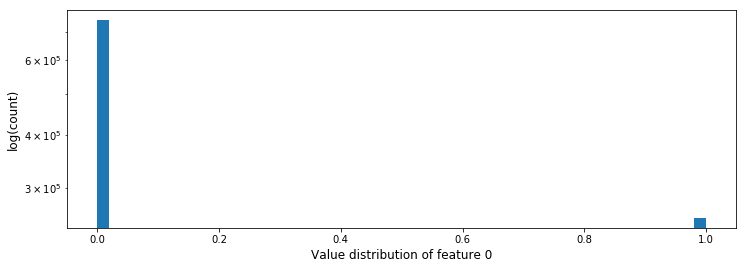

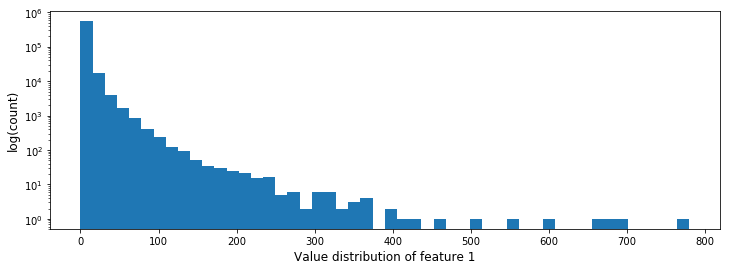

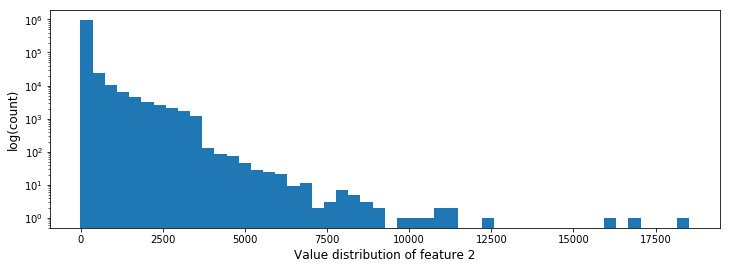

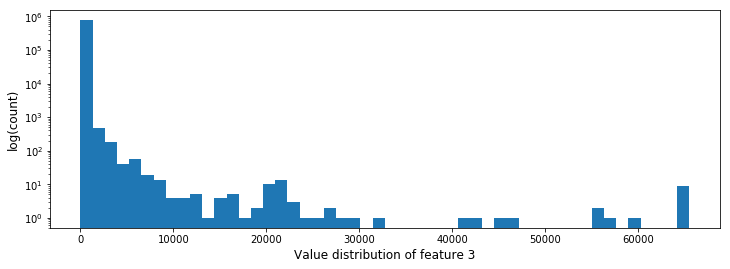

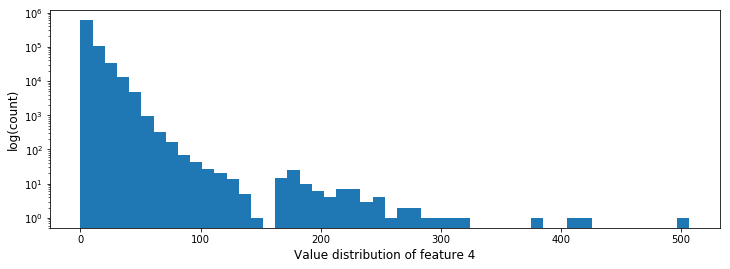

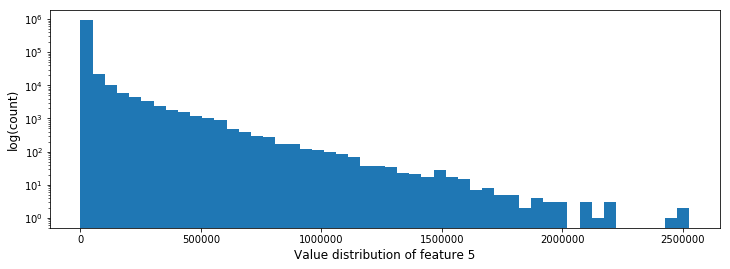

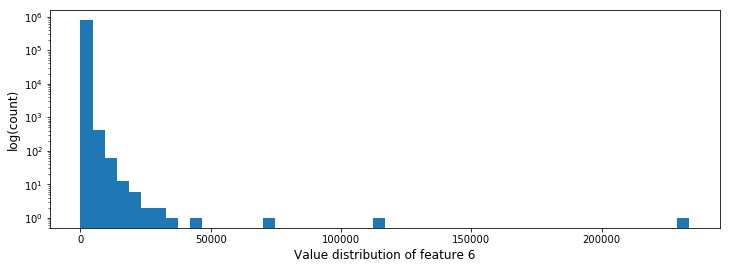

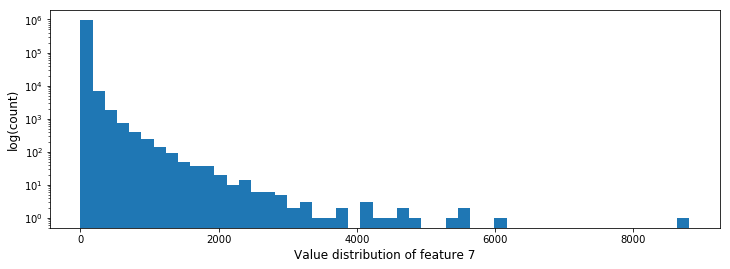

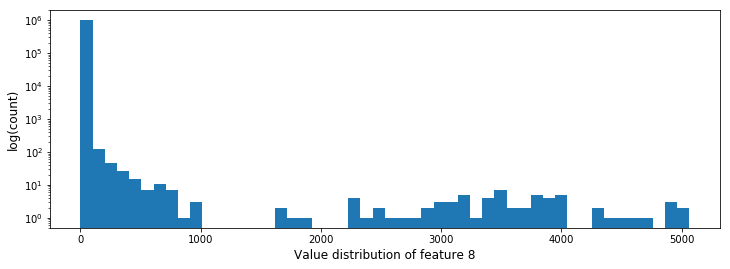

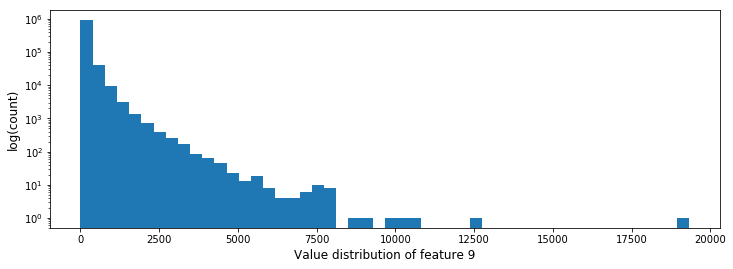

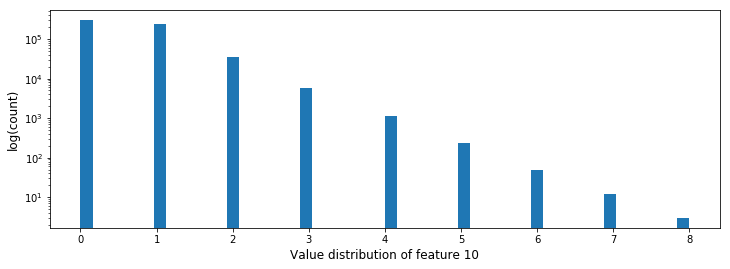

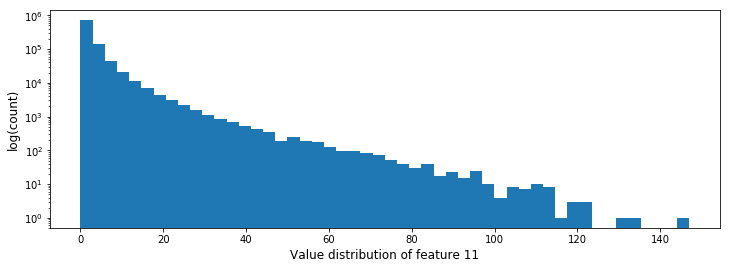

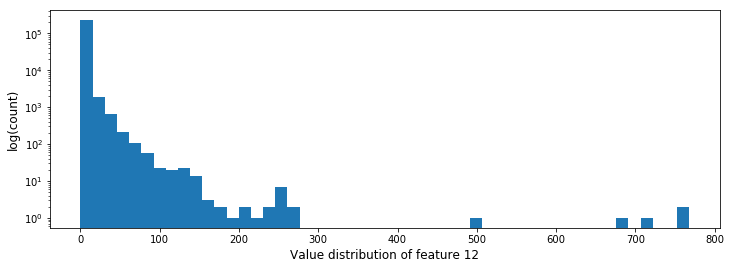

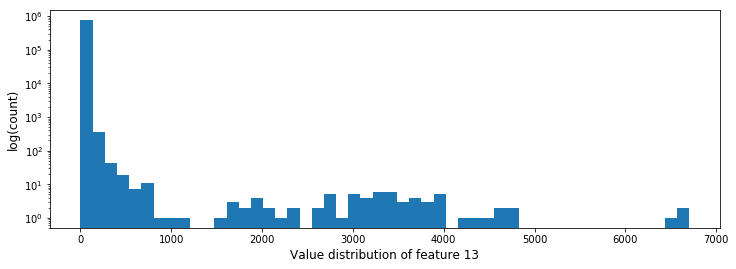

In [11]:
for featno in range(14):
    plt.figure(figsize=(12,4))
    plt.hist(eda[featno].dropna(), bins=50, log=True)
    plt.xlabel('Value distribution of feature {}'.format(featno), fontsize=12)
    plt.ylabel('log(count)', fontsize=12)
    plt.show()


There are a number of observations to be made:
  * Feature 0 is known to be our "clicked"/"not clicked" 1/0 label to be predicted.  We note that only ~25.5% of rows have feature 0 with value 1 ("clicked").
  * Most features hint at a [power law](https://en.wikipedia.org/wiki/Power_law "Wikipedia Power Law article") at work, having most values low with exponential drop-off of frequency with increase in value.
  * Some features, however, show other interesting regularities:
    * Feature 2 has a slower decay that drops abruptly between 2500 and 5000.
    * Features 3 and 4 feature a secondary peak and decay after a drop-off/gap.
    * Features 5, 10, and 11 don't have the exponential decay slope that would give us a line on a log-log plot, but rather have a linear feel to the decrease of their logarithmic frequency.
    * Features 8 and 13 have significant "humps" in their distribution tails.
  
The pandas_profiling package can give us an excellent profile of our features, including percent unique and missing values, as well as correlations:

In [12]:
pandas_profiling.ProfileReport(eda)

Number of variables,40
Number of observations,1000000
Total Missing (%),14.3%
Total size in memory,305.2 MiB
Average record size in memory,320.0 B
Numeric,13
Categorical,26
Boolean,1
Date,0
Text (Unique),0
Rejected,0


For our numeric features, we have significant numbers of missing values, skewed distributions, and large numbers of zeros.  Given that the numeric features are described as "mostly count features", a large number of zeros is not particularly worrisome. 
By "skewed distribution", the analysis indicates that there is a significant asymmetry to the distribution, and that the median value may be a more sensible substitute for a missing value than the mean value.

For example, the 2014 mean U.S. household income according to U.S. Census data was \$75,738.  However, given the positive skew of the household distribution, one would not say that \$75,738 would be a good guess for an unknown household income.  Rather, the 2014 median household income of $53,657 would be a better guess lacking other information.

For some of our data features with high-frequency occurrence of a few values, imputation (i.e. filling) of the missing values with the *mode* might be more appropriate, as the mode value is most likely the correct one.

Indeed, much as been written about how one should handle missing values.  There is a good summary of approaches in this [article by Alvira Walin](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4) where she summarizes approaches with this figure:

![missing data image](missing-data.png "Missing Data")

However, we will will be focused here on the application of gradient-boosted decision trees and field-aware factorization machines (FFMs), both of which can handle missing values.  Thus, we will make no effort to impute them.

FFMs are made to work with categorical data, so it is worth discussing how one should handle the discretization of numeric data. The winning Criteo team, "3 Idiots", prepended prefix "I#-" to each value, where # is the numeric feature number.  Missing values are represented by the prefix only. All other numbers are truncated to integers.  For resulting integer values <= 2, the prefix and "SP" are both prepended to the value (e.g. I2-SP1).  However, for integer values $x$ greater than two, the prefix is followed by $\lfloor \log(\lfloor x \rfloor)^2 \rfloor$.

For the maximum integers in the dataset, this means that we'll have at most a few hundred possible categories per numeric category.  Yet there are other approaches to discretizing numeric data, as nicely summarized in [Dipanjan Sarkar's article](https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b).

One could view the 3 Idiots team discretization as a form of fix-width binning where the first bins are for special values of missing, 0 <= x < 1, 1 <= x < 2, and 2 <= x < 3, followed by bins for values x >= 3 where bins are according to integer values $\lfloor \log(\lfloor x \rfloor)^2 \rfloor$.

One alternative is to perform adaptive binning on large data by sampling the data and forming bin ranges according to quantiles, and thus evenly distributing the data according to its distribution.  One problem with simple quantiles is that, for distributions like those we see here, frequently occurring low values may occupy many bins.  I would take a different adaptive binning approach with such positively skewed data. 

# TODO - Comparison of numeric binning techniques
(For now, just perform a simple hashing trick as in the logistic regression code above, but using a better hash (e.g. Murmurhash3).)




# XGBoost

We'll focus first on XGBoost as it has very strong representation amongst winning entries for many Kaggle competitions.  To quote Chen and Guestrin, "Among the 29 challenge winning solutions published at Kaggle's blog during 2015, 17 solutions [(59%)] used XGBoost.  Among these, eight [(28%)] solely used XGBoost to train the model, ..." ([Chen and Guestrin, 2016](https://arxiv.org/abs/1603.02754))

In all 3 CTR prediction contests he entered, Owen Zhang took 1st (Avito), 2nd (Avazu), and 22nd (Criteo) based on XGBoost as his primary tool ([Owen Zhang interview](http://blog.kaggle.com/2015/08/26/avito-winners-interview-1st-place-owen-zhang/)).  

Introductory materials for learning about gradient-boosted trees and XGBoost:

  * [XGBoost Python API](https://xgboost.readthedocs.io/en/latest/python/python_api.html); Note: XGBoost's data parameter can be "string/numpy array/scipy.sparse/pd.DataFrame/DataTable ... When data is string type, it represents the path libsvm format txt file, or binary file that xgboost can read from." 
  * [Kaggle tutorial](https://www.kaggle.com/dansbecker/learning-to-use-xgboost)
  * [Ieva Zarina's Simple XGBoost Tutorial Using the Iris Dataset](https://www.kdnuggets.com/2017/03/simple-xgboost-tutorial-iris-dataset.html)
  * [Official documentation, Get Started, Tutorials](https://xgboost.readthedocs.io/en/latest/get_started/index.html) and [Introduction to Boosted Trees](http://xgboost.readthedocs.io/en/latest/model.html)
  * YouTube videos:
      * [Trevor Hastie - Gradient Boosting Machine Learning](https://www.youtube.com/watch?v=wPqtzj5VZus)
      * [Jaroslaw Szymczak - Gradient Boosting in Practice: a deep dive into xgboost](https://www.youtube.com/watch?v=s3VmuVPfu0s)
      * [Parrot Prediction Practical XGBoost in Python Playlist](https://www.youtube.com/watch?v=c1nMonw5C9Q&list=PLZnYQQzkMilqTC12LmnN4WpQexB9raKQG)
  * Jason Brownlee articles: 
      * [A Gentle Introduction to XGBoost for Applied Machine Learning](https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/)
      * [Data Preparation for Gradient Boosting with XGBoost in Python](https://machinelearningmastery.com/data-preparation-gradient-boosting-xgboost-python/)

For more on the mathematics of gradient boosting, see [Cheng Li's slides](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf) and Chapter 10 of the book  [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn/)

Feature engineering is an important part of ML in general, but it would be good to gain perspective on how *much* feature engineering is necessary in this problem domain.  We will thus start to apply XGBoost with minimal feature engineering and apply successively more methods to see their comparative impact.

We'll approach the use of XGBoost by first ignoring all categorical data:

In [13]:
criteo_ml.xgb_counts_only()

Using Criteo count predictors only, ignoring categoricals:
10-fold cross validation with logloss metric, early stopping after 5 non-decreasing logloss iterations.
[0]	train-logloss:0.609382+0.000144399	test-logloss:0.60954+0.000431632
[1]	train-logloss:0.565149+0.000161114	test-logloss:0.565451+0.00082676
[2]	train-logloss:0.540098+0.000176035	test-logloss:0.540571+0.00112232
[3]	train-logloss:0.525514+0.000181744	test-logloss:0.526093+0.00133883
[4]	train-logloss:0.516828+0.000220119	test-logloss:0.517546+0.00149686
[5]	train-logloss:0.511584+0.000228553	test-logloss:0.512432+0.00164986
[6]	train-logloss:0.508337+0.000234308	test-logloss:0.509319+0.00176101
[7]	train-logloss:0.506256+0.000239774	test-logloss:0.507363+0.00184528
[8]	train-logloss:0.504835+0.000235799	test-logloss:0.506081+0.00191068
[9]	train-logloss:0.503854+0.000235719	test-logloss:0.505221+0.00196996
[10]	train-logloss:0.503108+0.000239314	test-logloss:0.504595+0.00198056
[11]	train-logloss:0.502521+0.000261429	test

In one run, after 77 boosting iterations, we had a test-logloss-mean of **0.501373**, which would be approximately 455/718 (~63%) on the private leaderboard if consistent.  Throwing away categorical data hurts performance considerably as expected in comparison to our logistic regression benchmark that achieved **0.469668** using the hashing trick to encode categorical data.

Next, we'll apply the hashing trick to encode categorical data in 1000 binary features:

In [14]:
hash_size = 1000
criteo_ml.xgb_categorical_hashing(hash_size)

Using Criteo count predictors and 1000-hashed categorical features:
10-fold cross validation with logloss metric, early stopping after 5 non-decreasing logloss iterations.
[0]	train-logloss:0.609089+0.000137998	test-logloss:0.609283+0.000465923
[1]	train-logloss:0.564433+0.000199113	test-logloss:0.564804+0.000870976
[2]	train-logloss:0.538765+0.000215569	test-logloss:0.539295+0.00111875
[3]	train-logloss:0.523466+0.000216893	test-logloss:0.524179+0.00138931
[4]	train-logloss:0.513846+0.000178987	test-logloss:0.514705+0.0015478
[5]	train-logloss:0.50759+0.000242712	test-logloss:0.508616+0.00165597
[6]	train-logloss:0.503189+0.000254233	test-logloss:0.504333+0.00179456
[7]	train-logloss:0.499931+0.000321413	test-logloss:0.501214+0.00178486
[8]	train-logloss:0.497477+0.000290373	test-logloss:0.498894+0.00184553
[9]	train-logloss:0.495463+0.000275157	test-logloss:0.49702+0.00191347
[10]	train-logloss:0.493711+0.000297577	test-logloss:0.495362+0.00188914
[11]	train-logloss:0.492185+0.000267

[111]	train-logloss:0.459803+0.000313152	test-logloss:0.471657+0.00185537
[112]	train-logloss:0.459642+0.000297311	test-logloss:0.471585+0.00186964
[113]	train-logloss:0.459479+0.000303866	test-logloss:0.471531+0.00188607
[114]	train-logloss:0.459337+0.000314398	test-logloss:0.47148+0.00189307
[115]	train-logloss:0.459184+0.000311733	test-logloss:0.471419+0.00189299
[116]	train-logloss:0.459014+0.00031914	test-logloss:0.471354+0.00189005
[117]	train-logloss:0.458869+0.000307104	test-logloss:0.471292+0.00190656
[118]	train-logloss:0.458723+0.000304053	test-logloss:0.471234+0.00189279
[119]	train-logloss:0.458565+0.00030128	test-logloss:0.47117+0.0018988
[120]	train-logloss:0.458401+0.000254831	test-logloss:0.471115+0.00190799
[121]	train-logloss:0.458247+0.000272863	test-logloss:0.471057+0.0018876
[122]	train-logloss:0.458114+0.000264959	test-logloss:0.471011+0.00189774
[123]	train-logloss:0.457981+0.000272081	test-logloss:0.470958+0.0018997
[124]	train-logloss:0.457846+0.000270631	test

[223]	train-logloss:0.446255+0.000271688	test-logloss:0.467591+0.00191123
[224]	train-logloss:0.446151+0.000289063	test-logloss:0.46756+0.00190939
[225]	train-logloss:0.446043+0.000326407	test-logloss:0.467528+0.00190708
[226]	train-logloss:0.445952+0.000325657	test-logloss:0.467504+0.00190464
[227]	train-logloss:0.445852+0.000340748	test-logloss:0.467479+0.00190276
[228]	train-logloss:0.445753+0.000341033	test-logloss:0.467455+0.00189755
[229]	train-logloss:0.445656+0.000330586	test-logloss:0.467431+0.00190161
[230]	train-logloss:0.445547+0.000332387	test-logloss:0.467408+0.00189509
[231]	train-logloss:0.445444+0.000332342	test-logloss:0.467385+0.00188634
[232]	train-logloss:0.445349+0.000348901	test-logloss:0.467365+0.00189052
[233]	train-logloss:0.445263+0.000338148	test-logloss:0.467346+0.00190513
[234]	train-logloss:0.445176+0.000345419	test-logloss:0.467327+0.00190262
[235]	train-logloss:0.445077+0.000341373	test-logloss:0.467303+0.001903
[236]	train-logloss:0.444982+0.000344327	

[335]	train-logloss:0.436709+0.000361324	test-logloss:0.465804+0.00188111
[336]	train-logloss:0.436632+0.000347912	test-logloss:0.465787+0.0018848
[337]	train-logloss:0.436559+0.000345491	test-logloss:0.465786+0.00188332
[338]	train-logloss:0.436505+0.000334302	test-logloss:0.465773+0.00188078
[339]	train-logloss:0.436453+0.00032642	test-logloss:0.465767+0.00187993
[340]	train-logloss:0.436378+0.000322379	test-logloss:0.465759+0.00188414
[341]	train-logloss:0.436306+0.000309449	test-logloss:0.465751+0.00189186
[342]	train-logloss:0.436246+0.000305472	test-logloss:0.465746+0.0018945
[343]	train-logloss:0.436175+0.000305483	test-logloss:0.465734+0.00189291
[344]	train-logloss:0.436108+0.000307447	test-logloss:0.465725+0.00189808
[345]	train-logloss:0.436046+0.000314608	test-logloss:0.465712+0.00188385
[346]	train-logloss:0.435976+0.00031047	test-logloss:0.465704+0.00189172
[347]	train-logloss:0.435904+0.000301359	test-logloss:0.465709+0.00188729
[348]	train-logloss:0.435829+0.00030479	te

[447]	train-logloss:0.429218+0.000290672	test-logloss:0.464994+0.00187313
[448]	train-logloss:0.429158+0.000283074	test-logloss:0.464989+0.00187882
[449]	train-logloss:0.429102+0.000280107	test-logloss:0.464976+0.00187956
[450]	train-logloss:0.429041+0.000285534	test-logloss:0.464971+0.00188838
[451]	train-logloss:0.42897+0.000318129	test-logloss:0.464962+0.00188192
[452]	train-logloss:0.428923+0.00032346	test-logloss:0.464961+0.00187498
[453]	train-logloss:0.428852+0.000335994	test-logloss:0.464964+0.00187709
[454]	train-logloss:0.428793+0.000336602	test-logloss:0.464968+0.00187646
[455]	train-logloss:0.428738+0.000329516	test-logloss:0.464962+0.00186533
[456]	train-logloss:0.428685+0.00032847	test-logloss:0.464956+0.00186391
[457]	train-logloss:0.428624+0.000339653	test-logloss:0.464954+0.00187168
[458]	train-logloss:0.428563+0.000340018	test-logloss:0.464948+0.00187464
[459]	train-logloss:0.428486+0.000339726	test-logloss:0.464945+0.0018638
[460]	train-logloss:0.428399+0.000342569	t

After 507 boosting iterations, we had a test-logloss-mean of *0.464817*, which would be approximately 205/718 (~29%) on the private leaderboard if consistent, and outperforms our logistic regression baseline performance of *0.469668* with three orders of magnitude fewer binary hashing features.  It's worth noting here that this very simple application of XGBoost with modest computational demands performs respectably. Recall that the competition winner had a log-loss of *0.444630*. 

Let's see what happens when we do the same with 10000 binary features and fewer collisions.

In [ ]:
criteo_ml.one_hot_most_freq_categories()

One-hot-encoding most frequent categorical values... 

# XGBoost parameter tuning